In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv('sales_data_sample.csv',encoding='unicode_escape')

In [3]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [4]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [5]:
df=df.drop(columns=['PHONE','ADDRESSLINE1','ADDRESSLINE2','STATE','POSTALCODE'])

In [6]:
import datetime as dt

In [7]:
df['ORDERDATE']=pd.to_datetime(df['ORDERDATE'])

In [8]:
snapshot_date=df['ORDERDATE'].max()+dt.timedelta(days=1)

In [9]:
df_RFM=df.groupby('CUSTOMERNAME').agg({
    'ORDERDATE':lambda x:(snapshot_date-x.max()).days,
    'ORDERNUMBER':'count',
    'SALES':'sum'
})

In [10]:
df_RFM.head()

,ORDERDATE,ORDERNUMBER,SALES
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [11]:
from sklearn.cluster import KMeans

In [12]:
data_log=np.log(df_RFM)

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler=StandardScaler()

In [15]:
scaler.fit(data_log)

StandardScaler()

In [16]:
data_normalized=scaler.transform(data_log)

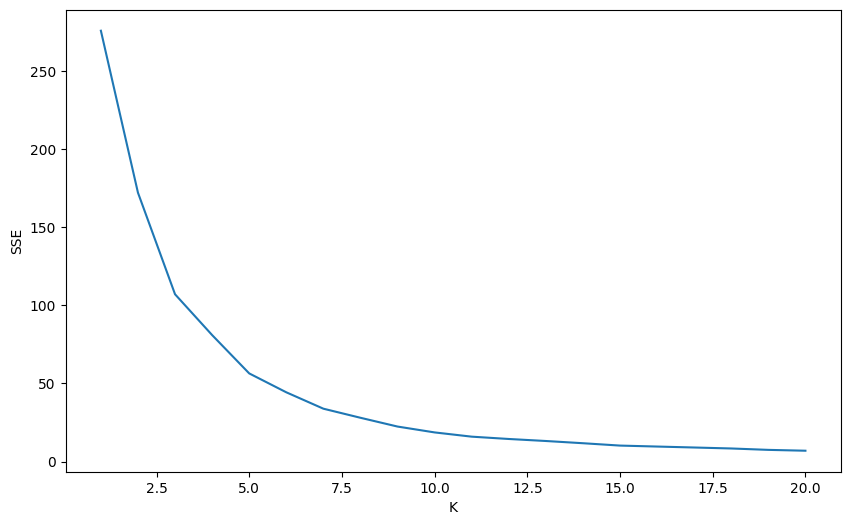

In [22]:
SSE={}
for k in range(1,21):
    kmeans=KMeans(n_clusters=k,random_state=1)
    kmeans.fit(data_normalized)
    SSE[k]=kmeans.inertia_ 

plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(list(SSE.keys()),list(SSE.values()))

In [23]:
print("Largest angle is at k=5")

Largest angle is at k=5


In [24]:
kmeans=KMeans(n_clusters=5,random_state=1)

In [25]:
kmeans.fit(data_normalized)

KMeans(n_clusters=5, random_state=1)

In [26]:
cluster_labels=kmeans.labels_

In [27]:
df_RFM=df_RFM.assign(Cluster=cluster_labels)

In [28]:
df_RFM.head()

,ORDERDATE,ORDERNUMBER,SALES,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,3
Alpha Cognac,65,20,70488.44,0
Amica Models & Co.,265,26,94117.26,0
"Anna's Decorations, Ltd",84,46,153996.13,3
Atelier graphique,188,7,24179.96,2


In [32]:
df_RFM.rename(columns={
    'ORDERDATE':'Recency',
    'ORDERNUMBER':'Frequency',
    'SALES':'Monetary'
},inplace=True
)

In [33]:
df_RFM.head()

,Recency,Frequency,Monetary,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,3
Alpha Cognac,65,20,70488.44,0
Amica Models & Co.,265,26,94117.26,0
"Anna's Decorations, Ltd",84,46,153996.13,3
Atelier graphique,188,7,24179.96,2


In [34]:
result=df_RFM.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
})

In [35]:
result

Recency   Frequency       Monetary      
               mean        mean           mean count
Cluster                                             
0        209.162791   22.093023   78633.205814    43
1          2.000000   38.750000  132201.635000     4
2        324.250000   10.666667   35628.653333    12
3        126.548387   37.129032  133158.014516    31
4          2.000000  219.500000  783576.085000     2